In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob
import os

In [3]:
files = glob.glob('data/PetImages/*/*.jpg')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image

In [41]:
from scipy.stats import entropy
def oent(outputs):
    out_entropy4 = []
    for o in outputs:
        A = o
        #for i in range(A.shape[0]):
        a = np.squeeze(A)
        n, c = np.histogram(a,16)
        p = n/sum(n)
        e = entropy(p)
        out_entropy4.append(e)
    return np.asarray(out_entropy4)

In [5]:
import pickle
with open('data/PetImages/train.pkl','rb') as fp:
    bpp_dic = pickle.load(fp)

In [6]:
from sklearn.model_selection import train_test_split
dataset = ImageFolder("data/PetImages/train/")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)
val_dataset = ImageFolder("data/cats-dogs/test_set/test_set/")
_,test_data,_,test_label = train_test_split(val_dataset.imgs,val_dataset.targets,test_size=0.999,random_state=42)
# ImageLoader Class

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None, bpp_thresh_cat = 100000,bpp_thresh_dog = 100000):
        self.dataset = self.checkChannel(dataset,bpp_thresh_cat,bpp_thresh_dog) # some images are CMYK, Grayscale, check only RGB 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        #print(self.dataset[item][0])
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory
        
    
    def checkChannel(self, dataset,bpp_thresh_cat = 100000,bpp_thresh_dog = 100000):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                if bpp_thresh_cat == 100000:
                    if 'data/PetImages/train/Cat/10889.jpg' == dataset[index][0]:
                        print('<<<<')
                    datasetRGB.append(dataset[index])
                else:
                    if ('Cat' in dataset[index][0] and bpp_dic[dataset[index][0]]<bpp_thresh_cat) or ('Dog' in dataset[index][0] and bpp_dic[dataset[index][0]]<bpp_thresh_dog):
                        #                     if np.random.rand()>0.65 :
                        datasetRGB.append(dataset[index])
                
        return datasetRGB

In [7]:
len(test_data)

2026

import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("data/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = bytes("JFIF",'utf-8') in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print(fpath)
            os.remove(fpath)

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  transforms.RandomHorizontalFlip(),transforms.RandomRotation(0.1),transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # test transform

train_dataset = ImageLoader(train_data, train_transform)#,bpp_thresh_cat=0.0425/1.25,bpp_thresh_dog=0.05/1.25)
test_dataset = ImageLoader(test_data, test_transform)

<<<<


In [9]:
print(train_dataset.__len__(),test_dataset.__len__())

16869 2026


In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
c = 0
for t in train_loader.dataset.dataset:
    c+=t[1]
print(c)
t

8442


('data/PetImages/train/Dog/4350.jpg', 1)

In [12]:
device = torch.device("cuda")

import torch
import torch.nn as nn
import torch.nn.functional as F



class Simple(nn.Module):
    def __init__(self, num_classes=10):
        
        super(Simple, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3)
        self.conv4 = nn.Conv2d(128,128,kernel_size=3)
        self.linear1 = nn.Linear(18432,512)
        self.linear2 = nn.Linear(512,num_classes)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out,2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out,2)
        out = F.relu(self.conv3(out))
        out = F.max_pool2d(out,2)
        out = F.relu(self.conv4(out))
        out = F.max_pool2d(out,2)
        #print("XXXX",out.shape)
        out = out.view(out.size(0), -1)
        
        #print("sss",out.shape)
        out = F.relu(self.linear1(out))
        features = out
        out = self.linear2(out)
        return out


In [23]:
from tqdm import tqdm
from torchvision import models
# load pretrain model and modify...
model = models.resnet18(pretrained=False)
#model = Simple(2)
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

# for param in model.parameters():
#     param.requires_grad = False

# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model.fc.in_features
# if args.no_dropout:
#     net.fc = nn.Linear(num_ftrs, 2)
# else:
print("applying dropout")
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 2)
)
model.to(device)


applying dropout


/home/ubuntu/anaconda3/envs/latest_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/latest_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
model = torch.nn.DataParallel(model)


In [25]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here


In [38]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

# Train and test

def train(num_epoch, model):
    writer = SummaryWriter('runs/LE')
    running_loss = 0
    for epoch in range(0, num_epoch):
        current_loss = 0.0
        current_corrects = 0
        losses = []
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
        
        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            losses.append(loss)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(scores, 1)
            current_loss += loss.item() * data.size(0)
            current_corrects += (preds == targets).sum().item()
            accuracy = int(current_corrects / len(train_loader.dataset) * 100)
            #loop.set_description(f"Epoch {epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
            #loop.set_postfix(loss=loss.data.item())
#             if batch_idx % 10 == 9:    # every 1000 mini-batches...
            #running_loss += loss.item()
#                 # ...log the running loss
        writer.add_scalar('training loss', current_loss,epoch )
        writer.add_scalar("Correct", current_corrects, epoch)
        writer.add_scalar("Accuracy", accuracy, epoch)
        # save model
        if epoch % 5 ==0:
            torch.save({ 
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 
                        }, 'checKpoint_epoch_'+str(epoch)+'.pt')


    writer.close()
# model.eval() is a kind of switch for some specific layers/parts of the model that behave differently,
# during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
# You need to turn off them during model evaluation, and .eval() will do it for you. In addition, 
# the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() 
# to turn off gradients computation:
        
def test():
    model.eval()
    test_loss = 0
    correct = 0
    out = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)
            out.extend(predictions.cpu().numpy())
            
    test_loss /= len(test_loader.dataset)
    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
    len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")
    return out, correct / len(test_loader.dataset)

In [27]:
outputs= []
def hook2(module, input, output):
    #print(len(output))
    outputs.append(output)
#a = model.layer4[1].conv2.register_forward_hook(hook2)
b = model.module.avgpool.register_forward_hook(hook2)
#c = model.linear1.register_forward_hook(hook2)

In [55]:
files = glob.glob('cats_dogs/Default_16869_0.081_0.085//checkpoint/*_*.pth')
out_ent = {}
out_med = {}
out_cov = {}
acc = {}
ind = {}
for f in files:
    name = f.split('/')[-1].split('_')[1].split('.')[0]
    checkpoint = torch.load(f)
    model.load_state_dict(checkpoint['net'])
    #print(name)
    outputs = []
    pred,o1 = test()
    ind[name] = np.where(pred==labels)[0]
    feat = []
    for o in outputs:
            A = o.cpu().numpy()
            for i in range(A.shape[0]):
                a = np.squeeze(A[i,:])
                feat.append(a)
    feat = np.asarray(feat)
    print(feat.shape)
    out_ent[int(name)] = oent(feat)
    out_cov[int(name)] = np.std(feat,1)/np.mean(feat,1)
    out_med[int(name)] = np.median(feat,1)
    acc[int(name)] = o1

Average Loss:  tensor(8.4604e-05, device='cuda:0')   Accuracy:  1892  /  2026    93 %
(2026, 512)
Average Loss:  tensor(6.5700e-05, device='cuda:0')   Accuracy:  1941  /  2026    95 %
(2026, 512)
Average Loss:  tensor(8.4076e-05, device='cuda:0')   Accuracy:  1892  /  2026    93 %
(2026, 512)
Average Loss:  tensor(6.0738e-05, device='cuda:0')   Accuracy:  1929  /  2026    95 %
(2026, 512)
Average Loss:  tensor(0.0001, device='cuda:0')   Accuracy:  1866  /  2026    92 %
(2026, 512)
Average Loss:  tensor(0.0001, device='cuda:0')   Accuracy:  1852  /  2026    91 %
(2026, 512)
Average Loss:  tensor(0.0002, device='cuda:0')   Accuracy:  1561  /  2026    77 %
(2026, 512)
Average Loss:  tensor(0.0001, device='cuda:0')   Accuracy:  1868  /  2026    92 %
(2026, 512)
Average Loss:  tensor(0.0003, device='cuda:0')   Accuracy:  1025  /  2026    50 %
(2026, 512)
Average Loss:  tensor(0.0001, device='cuda:0')   Accuracy:  1805  /  2026    89 %
(2026, 512)


In [54]:
labels = np.asarray(labels)

In [56]:
_ind = {}
for k in ind.keys():
    _ind[int(k)] = ind[k]
keylist = np.sort(list(_ind.keys()))
I = {}
for i,k in enumerate(keylist):
    tmp = _ind[k]
    for l in keylist[i+1:]:
        tmp = np.intersect1d(tmp,_ind[l])
    #print(i,k,tmp.shape)
    if i==0:
        I[k] = tmp
    else:
        for l in keylist[:i]:
            #print(tmp.shape,I[l].shape)
            tmp = np.setdiff1d(tmp,I[l])
            #print(tmp.shape)
        I[k] = tmp

In [57]:
ind

{'140': array([   0,    1,    2, ..., 2022, 2023, 2024]),
 '180': array([   0,    1,    2, ..., 2022, 2023, 2024]),
 '100': array([   0,    1,    2, ..., 2022, 2023, 2024]),
 '160': array([   0,    1,    2, ..., 2022, 2023, 2024]),
 '120': array([   0,    1,    2, ..., 2022, 2023, 2024]),
 '60': array([   0,    1,    2, ..., 2023, 2024, 2025]),
 '20': array([   0,    1,    2, ..., 2022, 2023, 2024]),
 '80': array([   0,    1,    2, ..., 2023, 2024, 2025]),
 '0': array([   1,    3,    5, ..., 2017, 2018, 2025]),
 '40': array([   0,    1,    2, ..., 2022, 2023, 2024])}

In [58]:
ff = np.zeros(2026)
for k in I.keys():
    for l in I[k]:
        ff[l] = int(k)
    

In [59]:
ff

array([20.,  0., 20., ..., 20., 20.,  0.])

In [60]:
oe = []
for k in np.sort(list(out_ent.keys())):
    print(k,np.count_nonzero(ff==k))
    oe.append(out_ent[int(k)])

0 681
20 752
40 267
60 74
80 50
100 45
120 24
140 52
160 62
180 19


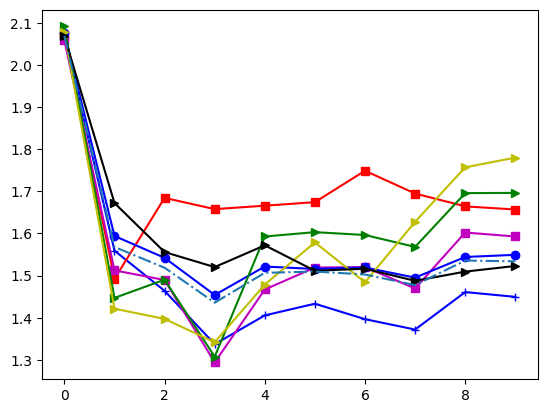

In [68]:
oe = np.asarray(oe)
doe = np.diff(oe,axis=0)
plt.plot(np.mean(oe[:,ff==20],1),'b-+')
plt.plot(np.mean(oe[:,ff==40],1),'r-s')
plt.plot(np.mean(oe[:,ff==80],1),'m-s')
plt.plot(np.mean(oe[:,np.random.choice(np.arange(2026),200)],1),'b-o')
plt.plot(np.mean(oe[:,ff==100],1),'g->')
plt.plot(np.mean(oe[:,ff==140],1),'y->')

plt.plot(np.mean(oe[:,ff==0],1),'k->')
plt.plot(np.mean(oe,1),'-.')
#plt.plot(doe[:,ff==40][:,0:10],'-s')
#plt.plot(doe[:,ff==100][:,0:10],'-<')

In [56]:
def get(dics,use_ent=False):
    acc = []
    ran = []
    ran_n = []
    lo = []
    lo_n = []
    hi = []
    hi_n = []
    bal = []
    bal_n = []
    hipr = []
    hipr_n = []
    lopr = []
    lopr_n = []
    hikm = []
    hikm_n = []
    lokm = []
    lokm_n = []
    for l in dics.keys():
            #print(l)
            if 'Ran_' in l:
                ran.append(dics[l])
                if use_ent:
                    ran_n.append(float(l.split('_')[1])*float(l.split('_')[2]))
                else:
                    ran_n.append(int(l.split('_')[1]))
            if 'Hi_' in l:
                hi.append(dics[l])
                if use_ent:
                    hi_n.append(float(l.split('_')[1])*float(l.split('_')[2]))
                else:
                    hi_n.append(int(l.split('_')[1]))
            if 'Lo_' in l:
                lo.append(dics[l])
                if use_ent:
                    lo_n.append(float(l.split('_')[1])*float(l.split('_')[2]))
                else:
                    lo_n.append(int(l.split('_')[1]))

            if 'Bal_' in l:
                bal.append(dics[l])
                bal_n.append(int(l.split('_')[1]))
            if 'HiPr' in l:
                hipr.append(dics[l])
                hipr_n.append(int(l.split('_')[1]))
            if 'LoPr' in l:
                lopr.append(dics[l])
                lopr_n.append(int(l.split('_')[1]))
            if 'HiKm' in l:
                hikm.append(dics[l])
                hikm_n.append(int(l.split('_')[1]))
            if 'LoKm' in l:
                lokm.append(dics[l])
                lokm_n.append(int(l.split('_')[1]))
    ran = np.asarray(ran)
    ran_n = np.asarray(ran_n)
    hi = np.asarray(hi)
    hi_n = np.asarray(hi_n)
    lo = np.asarray(lo)
    lo_n = np.asarray(lo_n)
    bal = np.asarray(bal)
    bal_n = np.asarray(bal_n)
    hipr = np.asarray(hipr)
    hipr_n = np.asarray(hipr_n)
    lopr = np.asarray(lopr)
    lopr_n = np.asarray(lopr_n)
    hikm = np.asarray(hikm)
    hikm_n = np.asarray(hikm_n)
    lokm = np.asarray(lokm)
    lokm_n = np.asarray(lokm_n)
    return ran, ran_n, hi, hi_n, lo, lo_n

train(30, model) # train
#test() # te5st

train(30, model) # train

In [17]:
train_dataset.__len__()

16869

In [30]:
checkpoint = torch.load('cats_dogs/Default_16869_0.081_0.085//checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['net'])
pred, o = test()

Average Loss:  tensor(6.4661e-05, device='cuda:0')   Accuracy:  1924  /  2026    94 %


In [37]:
labels = pred

In [25]:
import glob
dirs = glob.glob('cats_dogs/ft_iter_imgn//*')
dics = {}
for d in dirs:
    name = d.split('/')[2]
    if name in dics.keys():
        continue
    if 'Ran_' in name or 'Lo_' in name or 'Hi_' in name :
        checkpoint = torch.load(d+'/checkpoint/ckpt.pth')
#         if not os.path.exists(d+'/checkpoint/ckpt_180.pth'):
#             print("DOES NOT CNV")
#             continue
        model.load_state_dict(checkpoint['net'])
        print(name)
        pred,o = test()
        dics[name] = o

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.fc.1.weight", "module.fc.1.bias". 
	Unexpected key(s) in state_dict: "module.layer1.2.conv1.weight", "module.layer1.2.bn1.weight", "module.layer1.2.bn1.bias", "module.layer1.2.bn1.running_mean", "module.layer1.2.bn1.running_var", "module.layer1.2.bn1.num_batches_tracked", "module.layer1.2.conv2.weight", "module.layer1.2.bn2.weight", "module.layer1.2.bn2.bias", "module.layer1.2.bn2.running_mean", "module.layer1.2.bn2.running_var", "module.layer1.2.bn2.num_batches_tracked", "module.layer1.2.conv3.weight", "module.layer1.2.bn3.weight", "module.layer1.2.bn3.bias", "module.layer1.2.bn3.running_mean", "module.layer1.2.bn3.running_var", "module.layer1.2.bn3.num_batches_tracked", "module.layer1.0.conv3.weight", "module.layer1.0.bn3.weight", "module.layer1.0.bn3.bias", "module.layer1.0.bn3.running_mean", "module.layer1.0.bn3.running_var", "module.layer1.0.bn3.num_batches_tracked", "module.layer1.0.downsample.0.weight", "module.layer1.0.downsample.1.weight", "module.layer1.0.downsample.1.bias", "module.layer1.0.downsample.1.running_mean", "module.layer1.0.downsample.1.running_var", "module.layer1.0.downsample.1.num_batches_tracked", "module.layer1.1.conv3.weight", "module.layer1.1.bn3.weight", "module.layer1.1.bn3.bias", "module.layer1.1.bn3.running_mean", "module.layer1.1.bn3.running_var", "module.layer1.1.bn3.num_batches_tracked", "module.layer2.2.conv1.weight", "module.layer2.2.bn1.weight", "module.layer2.2.bn1.bias", "module.layer2.2.bn1.running_mean", "module.layer2.2.bn1.running_var", "module.layer2.2.bn1.num_batches_tracked", "module.layer2.2.conv2.weight", "module.layer2.2.bn2.weight", "module.layer2.2.bn2.bias", "module.layer2.2.bn2.running_mean", "module.layer2.2.bn2.running_var", "module.layer2.2.bn2.num_batches_tracked", "module.layer2.2.conv3.weight", "module.layer2.2.bn3.weight", "module.layer2.2.bn3.bias", "module.layer2.2.bn3.running_mean", "module.layer2.2.bn3.running_var", "module.layer2.2.bn3.num_batches_tracked", "module.layer2.3.conv1.weight", "module.layer2.3.bn1.weight", "module.layer2.3.bn1.bias", "module.layer2.3.bn1.running_mean", "module.layer2.3.bn1.running_var", "module.layer2.3.bn1.num_batches_tracked", "module.layer2.3.conv2.weight", "module.layer2.3.bn2.weight", "module.layer2.3.bn2.bias", "module.layer2.3.bn2.running_mean", "module.layer2.3.bn2.running_var", "module.layer2.3.bn2.num_batches_tracked", "module.layer2.3.conv3.weight", "module.layer2.3.bn3.weight", "module.layer2.3.bn3.bias", "module.layer2.3.bn3.running_mean", "module.layer2.3.bn3.running_var", "module.layer2.3.bn3.num_batches_tracked", "module.layer2.0.conv3.weight", "module.layer2.0.bn3.weight", "module.layer2.0.bn3.bias", "module.layer2.0.bn3.running_mean", "module.layer2.0.bn3.running_var", "module.layer2.0.bn3.num_batches_tracked", "module.layer2.1.conv3.weight", "module.layer2.1.bn3.weight", "module.layer2.1.bn3.bias", "module.layer2.1.bn3.running_mean", "module.layer2.1.bn3.running_var", "module.layer2.1.bn3.num_batches_tracked", "module.layer3.2.conv1.weight", "module.layer3.2.bn1.weight", "module.layer3.2.bn1.bias", "module.layer3.2.bn1.running_mean", "module.layer3.2.bn1.running_var", "module.layer3.2.bn1.num_batches_tracked", "module.layer3.2.conv2.weight", "module.layer3.2.bn2.weight", "module.layer3.2.bn2.bias", "module.layer3.2.bn2.running_mean", "module.layer3.2.bn2.running_var", "module.layer3.2.bn2.num_batches_tracked", "module.layer3.2.conv3.weight", "module.layer3.2.bn3.weight", "module.layer3.2.bn3.bias", "module.layer3.2.bn3.running_mean", "module.layer3.2.bn3.running_var", "module.layer3.2.bn3.num_batches_tracked", "module.layer3.3.conv1.weight", "module.layer3.3.bn1.weight", "module.layer3.3.bn1.bias", "module.layer3.3.bn1.running_mean", "module.layer3.3.bn1.running_var", "module.layer3.3.bn1.num_batches_tracked", "module.layer3.3.conv2.weight", "module.layer3.3.bn2.weight", "module.layer3.3.bn2.bias", "module.layer3.3.bn2.running_mean", "module.layer3.3.bn2.running_var", "module.layer3.3.bn2.num_batches_tracked", "module.layer3.3.conv3.weight", "module.layer3.3.bn3.weight", "module.layer3.3.bn3.bias", "module.layer3.3.bn3.running_mean", "module.layer3.3.bn3.running_var", "module.layer3.3.bn3.num_batches_tracked", "module.layer3.4.conv1.weight", "module.layer3.4.bn1.weight", "module.layer3.4.bn1.bias", "module.layer3.4.bn1.running_mean", "module.layer3.4.bn1.running_var", "module.layer3.4.bn1.num_batches_tracked", "module.layer3.4.conv2.weight", "module.layer3.4.bn2.weight", "module.layer3.4.bn2.bias", "module.layer3.4.bn2.running_mean", "module.layer3.4.bn2.running_var", "module.layer3.4.bn2.num_batches_tracked", "module.layer3.4.conv3.weight", "module.layer3.4.bn3.weight", "module.layer3.4.bn3.bias", "module.layer3.4.bn3.running_mean", "module.layer3.4.bn3.running_var", "module.layer3.4.bn3.num_batches_tracked", "module.layer3.5.conv1.weight", "module.layer3.5.bn1.weight", "module.layer3.5.bn1.bias", "module.layer3.5.bn1.running_mean", "module.layer3.5.bn1.running_var", "module.layer3.5.bn1.num_batches_tracked", "module.layer3.5.conv2.weight", "module.layer3.5.bn2.weight", "module.layer3.5.bn2.bias", "module.layer3.5.bn2.running_mean", "module.layer3.5.bn2.running_var", "module.layer3.5.bn2.num_batches_tracked", "module.layer3.5.conv3.weight", "module.layer3.5.bn3.weight", "module.layer3.5.bn3.bias", "module.layer3.5.bn3.running_mean", "module.layer3.5.bn3.running_var", "module.layer3.5.bn3.num_batches_tracked", "module.layer3.0.conv3.weight", "module.layer3.0.bn3.weight", "module.layer3.0.bn3.bias", "module.layer3.0.bn3.running_mean", "module.layer3.0.bn3.running_var", "module.layer3.0.bn3.num_batches_tracked", "module.layer3.1.conv3.weight", "module.layer3.1.bn3.weight", "module.layer3.1.bn3.bias", "module.layer3.1.bn3.running_mean", "module.layer3.1.bn3.running_var", "module.layer3.1.bn3.num_batches_tracked", "module.layer4.2.conv1.weight", "module.layer4.2.bn1.weight", "module.layer4.2.bn1.bias", "module.layer4.2.bn1.running_mean", "module.layer4.2.bn1.running_var", "module.layer4.2.bn1.num_batches_tracked", "module.layer4.2.conv2.weight", "module.layer4.2.bn2.weight", "module.layer4.2.bn2.bias", "module.layer4.2.bn2.running_mean", "module.layer4.2.bn2.running_var", "module.layer4.2.bn2.num_batches_tracked", "module.layer4.2.conv3.weight", "module.layer4.2.bn3.weight", "module.layer4.2.bn3.bias", "module.layer4.2.bn3.running_mean", "module.layer4.2.bn3.running_var", "module.layer4.2.bn3.num_batches_tracked", "module.layer4.0.conv3.weight", "module.layer4.0.bn3.weight", "module.layer4.0.bn3.bias", "module.layer4.0.bn3.running_mean", "module.layer4.0.bn3.running_var", "module.layer4.0.bn3.num_batches_tracked", "module.layer4.1.conv3.weight", "module.layer4.1.bn3.weight", "module.layer4.1.bn3.bias", "module.layer4.1.bn3.running_mean", "module.layer4.1.bn3.running_var", "module.layer4.1.bn3.num_batches_tracked". 
	size mismatch for module.layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for module.layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for module.layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for module.layer2.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for module.layer2.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for module.layer2.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for module.layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for module.layer2.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for module.layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for module.layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for module.layer3.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for module.layer3.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.layer3.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.layer3.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for module.layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for module.layer4.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for module.layer4.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for module.layer4.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for module.layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for module.layer4.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for module.layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).

In [23]:
import pickle
with open('cats_dogs/ft_iter_imgn//res.pkl','wb') as fp:
    pickle.dump(dics,fp)

In [28]:
with open('cats_dogs/iter1/res.pkl','rb') as fp:
    dics = pickle.load(fp)
with open('cats_dogs/iter2/res.pkl','rb') as fp:
    dics1 = pickle.load(fp)
# with open('cats_dogs/iter2/res.pkl','rb') as fp:
#     dics2 = pickle.load(fp)

Hi_10121_0.109_0.101 0.9251184834123223
Hi_15181_0.087_0.088 0.9158767772511849
Hi_1686_0.274_0.160 0.7286729857819905
Hi_3373_0.193_0.139 0.8009478672985783
Hi_5060_0.156_0.125 0.859478672985782
Hi_5903_0.144_0.120 0.8812796208530805
Hi_6746_0.134_0.115 0.8928909952606635
Hi_8434_0.120_0.107 0.906872037914692
Lo_10121_0.046_0.011 0.931042654028436
Lo_1686_0.030_0.005 0.7246445497630332
Lo_3373_0.034_0.006 0.8071090047393364
Lo_4216_0.036_0.006 0.8471563981042654
Lo_5060_0.037_0.006 0.8495260663507109
Lo_5903_0.039_0.007 0.9130331753554503
Lo_6746_0.040_0.008 0.8767772511848341
Lo_8434_0.043_0.009 0.9177725118483412
Ran_1686_0.080_0.089 0.7362559241706161
Ran_3373_0.080_0.083 0.8348341232227489
Ran_4217_0.081_0.080 0.8848341232227488
Ran_5060_0.082_0.086 0.8862559241706162
Ran_5904_0.082_0.089 0.9026066350710901
Ran_6746_0.082_0.083 0.9137440758293839
a 
Hi_1686_0.274_0.160 0.7428909952606635
Hi_3373_0.193_0.139 0.8255924170616113
Hi_5060_0.156_0.125 0.8651658767772512
Hi_5903_0.144_0.

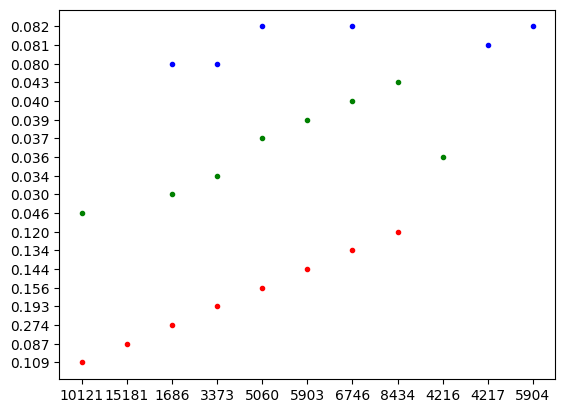

In [35]:
for n in np.sort(list(dics.keys())):
    print(n,dics[n])
    if 'Hi_' in n:
        plt.plot(n.split('_')[1],n.split('_')[2],'r.')
    if 'Lo_' in n:
        plt.plot(n.split('_')[1],n.split('_')[2],'g.')
    if 'Ran_' in n:
        plt.plot(n.split('_')[1],n.split('_')[2],'b.')
print("a ")
for n in np.sort(list(dics1.keys())):
    print(n,dics1[n])
print("a ")
# for n in np.sort(list(dics2.keys())):
#     print(n,dics2[n])
# print("a ")
# for n in np.sort(list(dics3.keys())):
#     print(n,dics3[n])


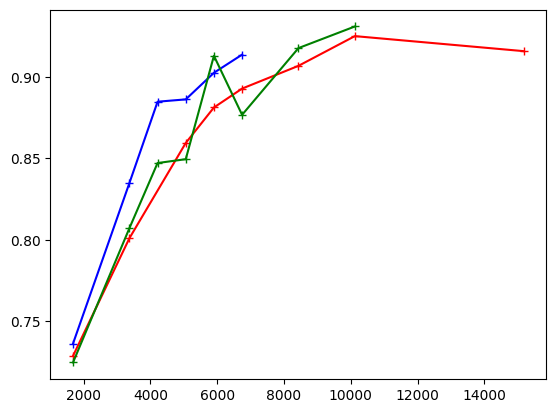

In [29]:
ran, ran_n, hi, hi_n, lo, lo_n = get(dics)
plt.plot(ran_n[np.argsort(ran_n)],ran[np.argsort(ran_n)],'b-+')
plt.plot(hi_n[np.argsort(hi_n)],hi[np.argsort(hi_n)],'r-+')
plt.plot(lo_n[np.argsort(lo_n)],lo[np.argsort(lo_n)],'g-+')
#plt.plot(hipr_n[np.argsort(hipr_n)],hipr[np.argsort(hipr_n)],'k-+')
#plt.plot(lopr_n[np.argsort(lopr_n)],lopr[np.argsort(lopr_n)],'c-+')

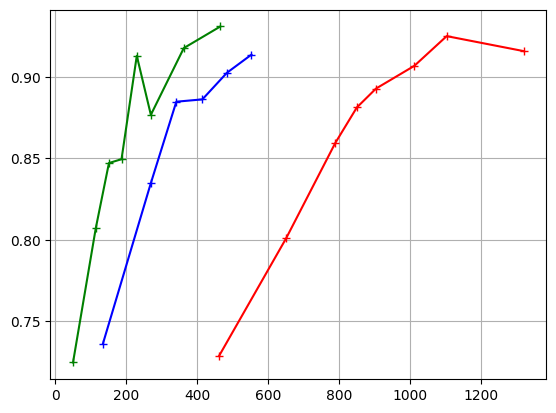

In [38]:
ran, ran_n, hi, hi_n, lo, lo_n = get(dics,True)
plt.plot(ran_n[np.argsort(ran_n)],ran[np.argsort(ran_n)],'b-+')
plt.plot(hi_n[np.argsort(hi_n)],hi[np.argsort(hi_n)],'r-+')
plt.plot(lo_n[np.argsort(lo_n)],lo[np.argsort(lo_n)],'g-+')
plt.grid('on')

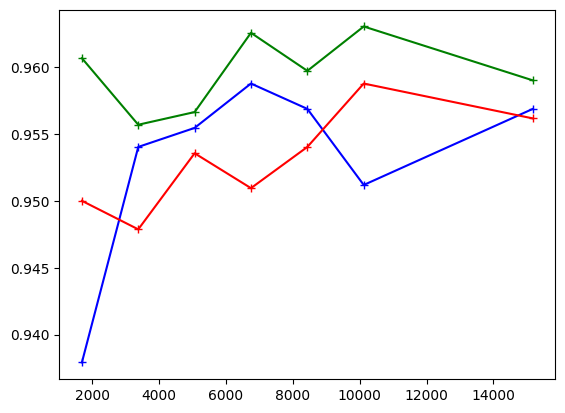

In [24]:
ran, ran_n, hi, hi_n, lo, lo_n = get(dics)
plt.plot(ran_n[np.argsort(ran_n)],ran[np.argsort(ran_n)],'b-+')
plt.plot(hi_n[np.argsort(hi_n)],hi[np.argsort(hi_n)],'r-+')
plt.plot(lo_n[np.argsort(lo_n)],lo[np.argsort(lo_n)],'g-+')
#plt.plot(hipr_n[np.argsort(hipr_n)],hipr[np.argsort(hipr_n)],'k-+')
#plt.plot(lopr_n[np.argsort(lopr_n)],lopr[np.argsort(lopr_n)],'c-+')

In [31]:
key = []
for k in dics.keys():
    key.append('_'.join(k.split('_')[:2]))
for k in dics1.keys():
    key.append('_'.join(k.split('_')[:2]))

_dics = {}
for k in key:
    v = []
    for l in dics.keys():
        if k in l:
            v.append(dics[l])
    for l in dics1.keys():
        if k in l:
            v.append(dics1[l])
    _dics[k] = np.mean(v)

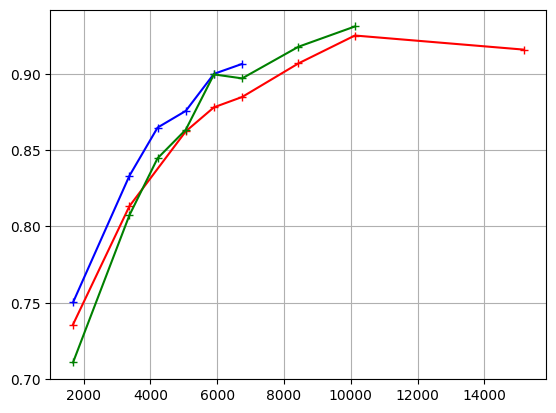

In [32]:
ran, ran_n, hi, hi_n, lo, lo_n = get(_dics)
plt.plot(ran_n[np.argsort(ran_n)],ran[np.argsort(ran_n)],'b-+')
plt.plot(hi_n[np.argsort(hi_n)],hi[np.argsort(hi_n)],'r-+')
plt.plot(lo_n[np.argsort(lo_n)],lo[np.argsort(lo_n)],'g-+')
plt.grid('on')

In [79]:
feat = np.asarray(feat)

In [109]:
outputs= []
def hook2(module, input, output):
    #print(len(output))
    outputs.append(output)
#a = model.layer4[1].conv2.register_forward_hook(hook2)
b = model.module.avgpool.register_forward_hook(hook2)
#c = model.linear1.register_forward_hook(hook2)

In [129]:
checkpoint = torch.load('cats_dogs/iter2/Lo_6746_0.040_0.008//checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

a.remove()

In [130]:
outputs = []
pred = test()

Average Loss:  tensor(0.0001, device='cuda:0')   Accuracy:  1877  /  2026    92 %


In [132]:
feat = []
for o in outputs:
        A = o.cpu().numpy()
        for i in range(A.shape[0]):
            a = np.squeeze(A[i,:])
            feat.append(a)

In [133]:
feat = np.asarray(feat)

In [139]:
feat.shape

(2026, 512)

In [134]:
from sklearn.neighbors import kneighbors_graph

In [135]:
G = kneighbors_graph(feat,100)

In [136]:
G

<2026x2026 sparse matrix of type '<class 'numpy.float64'>'
	with 202600 stored elements in Compressed Sparse Row format>

In [137]:
adj = G.toarray()>0

In [65]:
from sknetwork.ranking import PageRank

In [66]:
pagerank = PageRank()
scores = pagerank.fit_predict(G.toarray())



In [67]:
ind = np.argsort(scores)[::-1]

In [64]:
files = test_loader.dataset.dataset
files

[('data/cats-dogs/test_set/test_set/dogs/dog.4265.jpg', 1),
 ('data/cats-dogs/test_set/test_set/cats/cat.4972.jpg', 0),
 ('data/cats-dogs/test_set/test_set/dogs/dog.4523.jpg', 1),
 ('data/cats-dogs/test_set/test_set/cats/cat.4588.jpg', 0),
 ('data/cats-dogs/test_set/test_set/dogs/dog.4273.jpg', 1),
 ('data/cats-dogs/test_set/test_set/cats/cat.4773.jpg', 0),
 ('data/cats-dogs/test_set/test_set/dogs/dog.4557.jpg', 1),
 ('data/cats-dogs/test_set/test_set/cats/cat.4363.jpg', 0),
 ('data/cats-dogs/test_set/test_set/dogs/dog.4678.jpg', 1),
 ('data/cats-dogs/test_set/test_set/dogs/dog.4766.jpg', 1),
 ('data/cats-dogs/test_set/test_set/cats/cat.4514.jpg', 0),
 ('data/cats-dogs/test_set/test_set/cats/cat.4247.jpg', 0),
 ('data/cats-dogs/test_set/test_set/cats/cat.4466.jpg', 0),
 ('data/cats-dogs/test_set/test_set/cats/cat.4378.jpg', 0),
 ('data/cats-dogs/test_set/test_set/dogs/dog.4988.jpg', 1),
 ('data/cats-dogs/test_set/test_set/cats/cat.4602.jpg', 0),
 ('data/cats-dogs/test_set/test_set/dogs

In [73]:
dic = {}
for i,f in enumerate(files):
    dic[f[0]] = np.log10(scores)[i]

In [38]:
len(feat)

4220

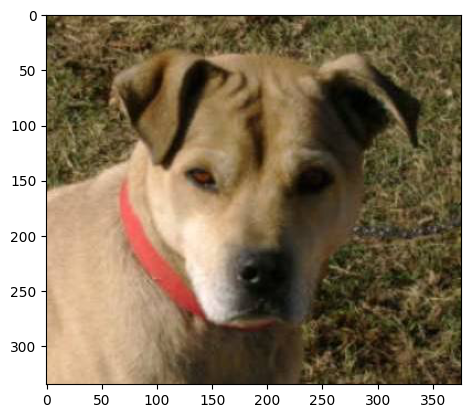

In [65]:
x = np.random.choice(len(files))
plt.imshow(plt.imread(files[x][0]))
#print(scores[ind[0]])

In [80]:
np.mean(list(dic.values()))

-4.655876916063628

(array([4677., 2648., 2041., 1717., 1445., 1274., 1017., 1017.,  869.,
         770.,  702.,  606.,  479.,  425.,  347.,  281.,  204.,  192.,
         139.,   91.,   66.,   36.,   23.,   13.,    8.]),
 array([-5.14792354, -5.05264695, -4.95737037, -4.86209379, -4.7668172 ,
        -4.67154062, -4.57626403, -4.48098745, -4.38571086, -4.29043428,
        -4.1951577 , -4.09988111, -4.00460453, -3.90932794, -3.81405136,
        -3.71877477, -3.62349819, -3.52822161, -3.43294502, -3.33766844,
        -3.24239185, -3.14711527, -3.05183868, -2.9565621 , -2.86128552,
        -2.76600893]),
 <BarContainer object of 25 artists>)

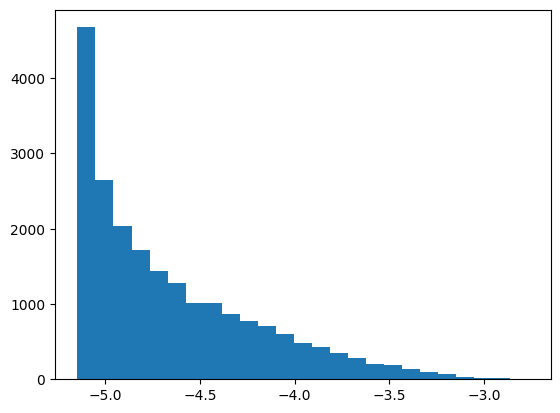

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(dic.values()),25)

(array([4677., 2648., 2041., 1717., 1445., 1274., 1017., 1017.,  869.,
         770.,  702.,  606.,  479.,  425.,  347.,  281.,  204.,  192.,
         139.,   91.,   66.,   36.,   23.,   13.,    8.]),
 array([-5.14792354, -5.05264695, -4.95737037, -4.86209379, -4.7668172 ,
        -4.67154062, -4.57626403, -4.48098745, -4.38571086, -4.29043428,
        -4.1951577 , -4.09988111, -4.00460453, -3.90932794, -3.81405136,
        -3.71877477, -3.62349819, -3.52822161, -3.43294502, -3.33766844,
        -3.24239185, -3.14711527, -3.05183868, -2.9565621 , -2.86128552,
        -2.76600893]),
 <BarContainer object of 25 artists>)

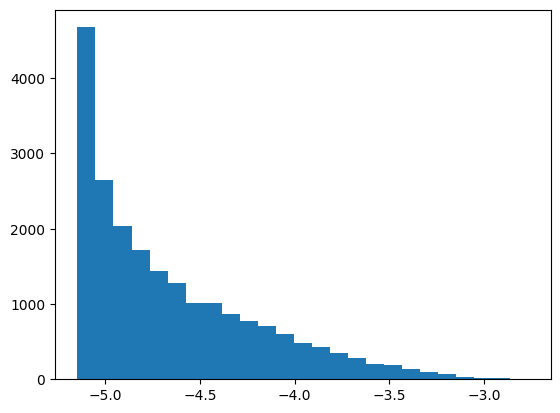

In [36]:
plt.hist(np.log10(scores),25)

In [98]:
np.diag(adj)

array([False, False, False, ..., False, False, False])

In [72]:
labels = []
for i in range(len(files)):
    labels.append(int(files[i][1]))
labels = np.asarray(labels)

import os
sz = []
labels = []
files = []
for d,l in test_loader.dataset.dataset:
    #print(d)
    if 'dogs' in d:
        sz.append(os.path.getsize(d.replace('/training_set/dogs/','/training_set_224/dogs/')))
    elif 'cats' in d:
        sz.append(os.path.getsize(d.replace('/training_set/cats/','/training_set_224/cats/')))
    labels.append(l)
    files.append(d)

In [73]:
in_entropy = []
labels = []
files = []
for d,l in test_loader.dataset.dataset:
    sz = os.path.getsize(d)
    labels.append(l)
    files.append(d)
    dim = plt.imread(d).size
    in_entropy.append(sz/dim)
in_entropy = np.asarray(in_entropy)
labels = np.asarray(labels)

In [74]:
labels[0]

1

In [76]:
labels[np.where(adj[0,:])]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [77]:
in_entropy[0]

0.045436507936507935

In [80]:
np.mean(in_entropy[np.where(adj[0,:])])

0.056964064608482134

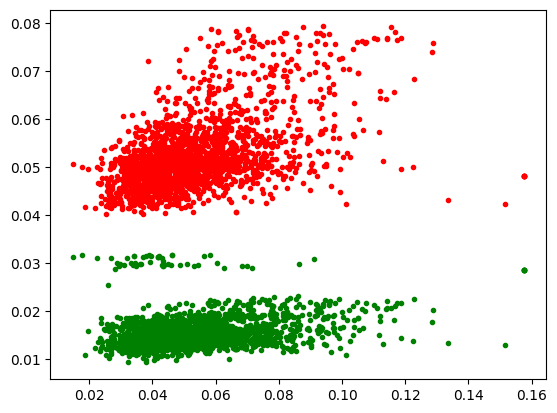

In [86]:
#plt.plot(in_entropy,'.')
for i in np.arange(len(in_entropy)):
    plt.plot(in_entropy[i],np.mean(in_entropy[np.where(adj[i,:])]),'r.')
    plt.plot(in_entropy[i],np.std(in_entropy[np.where(adj[i,:])]),'g.')

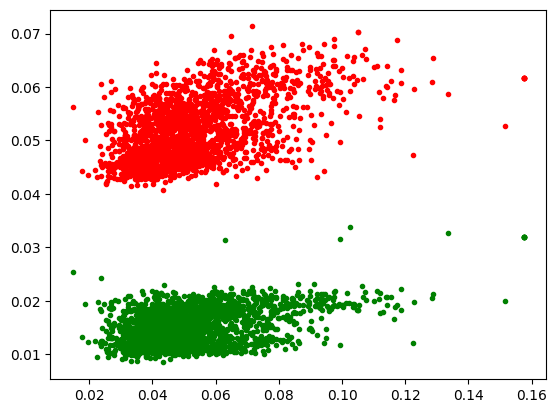

In [99]:
for i in np.arange(len(in_entropy)):
    plt.plot(in_entropy[i],np.mean(in_entropy[np.where(adj[i,:])]),'r.')
    plt.plot(in_entropy[i],np.std(in_entropy[np.where(adj[i,:])]),'g.')

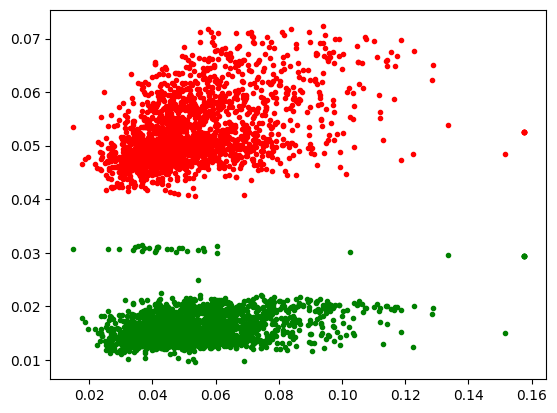

In [119]:
for i in np.arange(len(in_entropy)):
    plt.plot(in_entropy[i],np.mean(in_entropy[np.where(adj[i,:])]),'r.')
    plt.plot(in_entropy[i],np.std(in_entropy[np.where(adj[i,:])]),'g.')

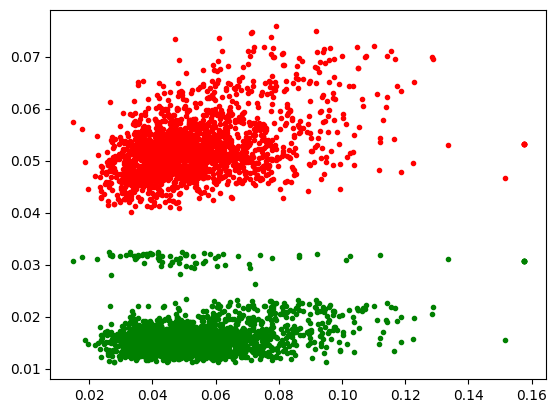

In [128]:
for i in np.arange(len(in_entropy)):
    plt.plot(in_entropy[i],np.mean(in_entropy[np.where(adj[i,:])]),'r.')
    plt.plot(in_entropy[i],np.std(in_entropy[np.where(adj[i,:])]),'g.')

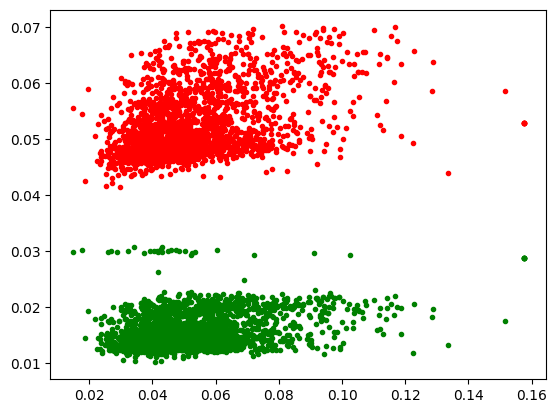

In [138]:
for i in np.arange(len(in_entropy)):
    plt.plot(in_entropy[i],np.mean(in_entropy[np.where(adj[i,:])]),'r.')
    plt.plot(in_entropy[i],np.std(in_entropy[np.where(adj[i,:])]),'g.')

In [25]:
out_entropy15 = oent(outputs)

In [26]:
in_entropy.shape


(4220,)

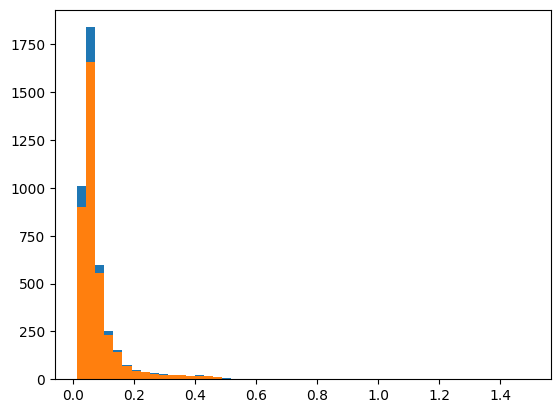

In [80]:
_=plt.hist(in_entropy,50)
_=plt.hist(in_entropy[pred==labels],50)
lo_pred = pred

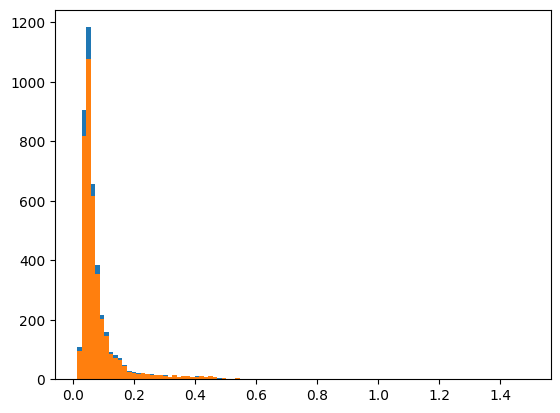

In [75]:
x=plt.hist(np.asarray(in_entropy),100)
_=plt.hist(in_entropy[pred==labels],x[1])
ran_pred = pred

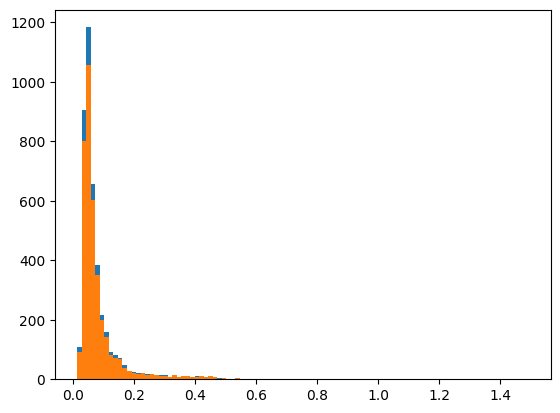

In [86]:
x=plt.hist(np.asarray(in_entropy),100)
_=plt.hist(in_entropy[pred==labels],x[1])
hi_pred = pred

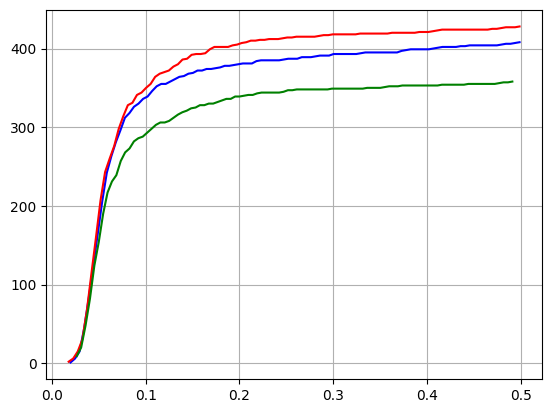

In [87]:
# x=plt.hist(in_entropy[ran_pred==labels],50)
# _=plt.hist(in_entropy[lo_pred==labels],x[1])
# _=plt.hist(in_entropy[hi_pred==labels],x[1])
ind = np.where(np.logical_and(in_entropy>0.01,in_entropy<0.5))
test_size = in_entropy[ind]
x=np.histogram(np.asarray(test_size)[np.asarray(lo_pred)[ind]!=labels[ind]],100)
plt.plot(x[1][1:],np.cumsum(x[0]),'b')
x=np.histogram(np.asarray(test_size)[np.asarray(hi_pred)[ind]!=labels[ind]],100)
plt.plot(x[1][1:],np.cumsum(x[0]),'r')
x=np.histogram(np.asarray(test_size)[np.asarray(ran_pred)[ind]!=labels[ind]],100)
plt.plot(x[1][1:],np.cumsum(x[0]),'g')
plt.grid('on')

In [60]:
x

(array([ 9, 11, 28, 34, 42, 30, 36, 27, 14,  8, 18, 11,  5,  9,  4,  2,  5,
         5,  5,  3,  0,  2,  4,  4,  3,  2,  3,  1,  3,  0,  2,  0,  2,  2,
         2,  0,  3,  0,  1,  1,  0,  2,  1,  0,  0,  0,  0,  1,  2,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1]),
 array([0.021696  , 0.02638996, 0.03108392, 0.03577788, 0.04047184,
        0.0451658 , 0.04985976, 0.05455372, 0.05924768, 0.06394164,
        0.0686356 , 0.07332955, 0.07802351, 0.08271747, 0.08741143,
        0.09210539, 0.09679935, 0.10149331, 0.10618727, 0.11088123,
        0.11557519, 0.12026915, 0.12496311, 0.12965707, 0.13435103,
        0.13904499, 0.14373895, 0.14843291, 0.15312687, 0.15782083,
        0.16251479, 0.16720875, 0.17190271, 0.17659666, 0.18129062,
        0.18598458, 0.19067854, 0.1953725 , 0.20006646, 0.20476042,
      

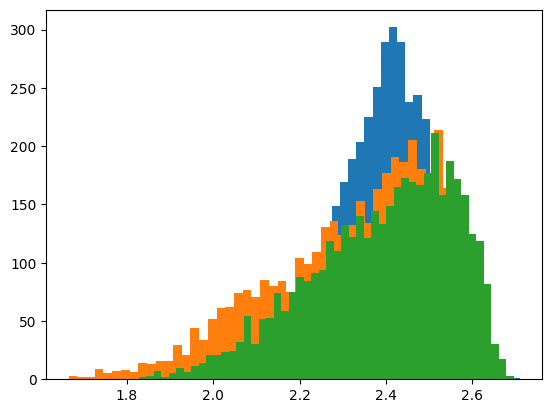

In [49]:
_=plt.hist(out_entropy0,50)
_=plt.hist(out_entropy15,50)
_=plt.hist(out_entropy,50)


#


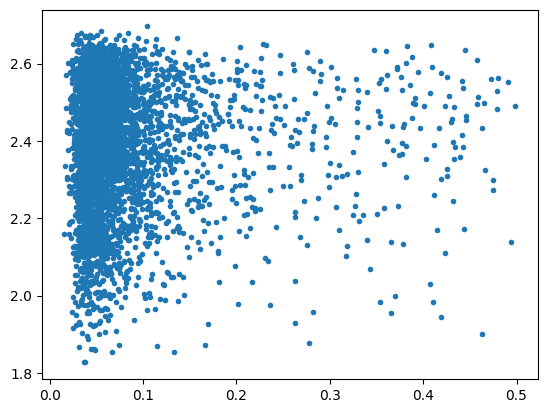

In [53]:
plt.plot(in_entropy[in_entropy<0.5],out_entropy[in_entropy<0.5],'.')
#plt.plot(in_entropy[pred!=labels],out_entropy[pred!=labels],'.')
#plt.plot(in_entropy,out_entropy0,'.')
#plt.plot(in_entropy[pred!=labels],out_entropy0[pred!=labels],'.')
#plt.plot(sz,out_entropy2,'.')
#plt.plot(sz,out_entropy3,'.')
#plt.plot(sz,out_entropy4,'.')

In [75]:
np.where(in_entropy>0.8)

(array([ 130,  537, 2121, 3083, 3570, 4092]),)

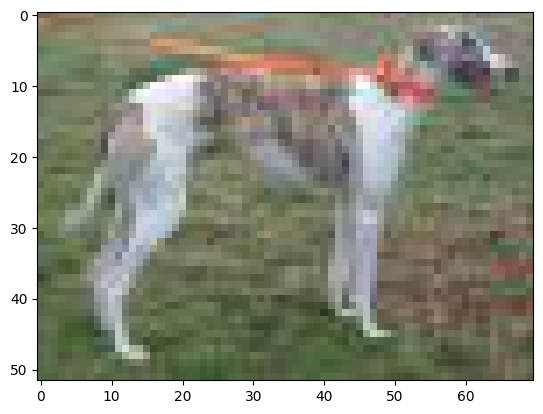

In [80]:
plt.imshow(plt.imread(files[130]))

In [36]:
print(np.mean(out_entropy0),np.std(out_entropy0))

print(np.mean(out_entropy),np.std(out_entropy))
print(np.mean(in_entropy),np.std(in_entropy))
# print(np.mean(out_entropy2),np.std(out_entropy2))
# print(np.mean(out_entropy3),np.std(out_entropy3))
# print(np.mean(out_entropy4),np.std(out_entropy4))

2.3735571713319485 0.1306864077983946
2.3903787106516035 0.16617549448593902
0.08183330118633594 0.08736152588769248


In [60]:
np.where(np.logical_and(sz>30000,out_entropy>1.6))

(array([], dtype=int64),)

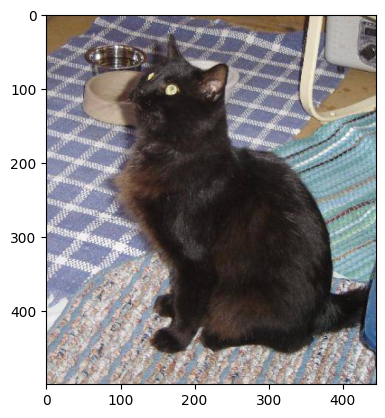

In [99]:
plt.imshow(plt.imread(files[754]))

In [32]:
pred = np.asarray(pred)
labels = np.asarray(labels)
sz = np.asarray(sz)

In [31]:
np.count_nonzero(pred==labels)

3876

In [34]:
print(np.mean(in_entropy[pred==labels]),np.std(np.asarray(in_entropy)[pred==labels]))
#print(np.mean(np.asarray(out_entropy)[pred==labels]),np.std(np.asarray(out_entropy)[pred==labels]))


0.08302840054559657 0.08720210805351004


In [35]:
print(np.mean(np.asarray(in_entropy)[pred!=labels]),np.std(np.asarray(in_entropy)[pred!=labels]))
#print(np.mean(out_entropy[pred!=labels]),np.std(np.asarray(out_entropy)[pred!=labels]))

0.08065689112804551 0.09566527984578527


In [36]:
print(np.mean(np.asarray(in_entropy)),np.std(np.asarray(in_entropy)))
#print(np.mean(out_entropy),np.std(np.asarray(out_entropy)))

0.08283508319023221 0.08792489357244361


26016


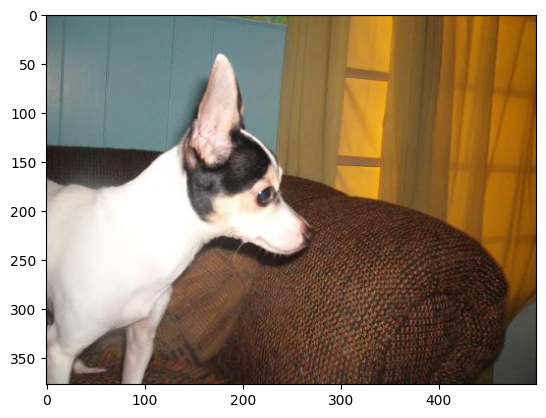

In [48]:
f = np.random.choice(np.asarray(files)[pred!=labels])
print(os.path.getsize(f.replace('/training_set/training_set/','/training_set/training_set_224/')))
plt.imshow(plt.imread(f.replace('/training_set/training_set/','/training_set/training_set/')))
im = plt.imread(f.replace('/training_set/training_set/','/training_set/training_set/'))

In [39]:
sz

array(23338)

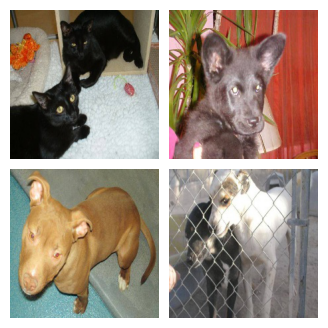

21648
25385
23838
25737


In [73]:
from mpl_toolkits.axes_grid1 import ImageGrid
_files = np.asarray(files)[sz>25000]
f = np.random.choice(_files,4)
f = np.random.choice(np.asarray(files)[pred!=labels],4)
im1 = plt.imread(f[0].replace('/training_set/training_set/','/training_set/training_set_224/'))

im2 = plt.imread(f[1].replace('/training_set/training_set/','/training_set/training_set_224/'))

im3 = plt.imread(f[2].replace('/training_set/training_set/','/training_set/training_set_224/'))
#f = np.random.choice(np.asarray(files)[pred!=labels])
im4 = plt.imread(f[3].replace('/training_set/training_set/','/training_set/training_set_224/'))
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
plt.show()
for i in range(4):
    print(os.path.getsize(f[i].replace('/training_set/training_set/','/training_set/training_set_224/')))

In [70]:
import cv2

In [24]:
cv2.__version__

'4.7.0'

In [38]:
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(im)

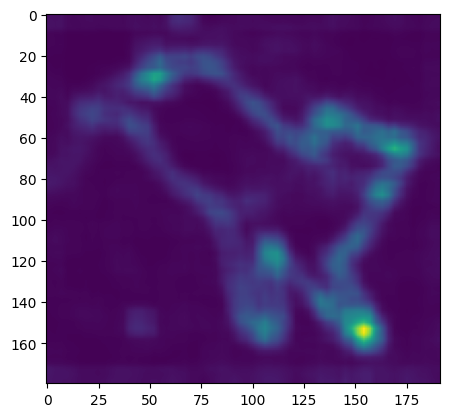

In [39]:
plt.imshow(saliencyMap)

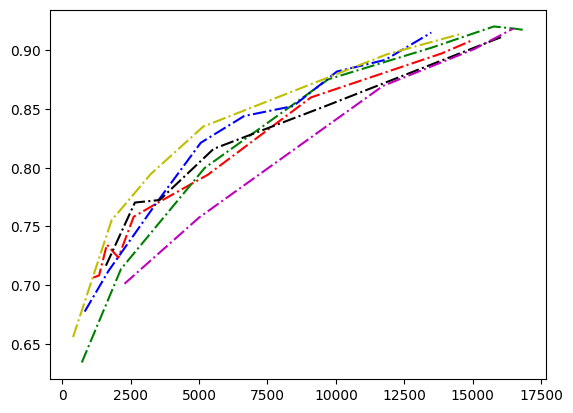

In [35]:
plt.plot(np.sort(hi_n),np.asarray(hi)[np.argsort(hi_n)],'r-.')
plt.plot(np.sort(lo_n),np.asarray(lo)[np.argsort(lo_n)],'g-.')
plt.plot(np.sort(ran_n),np.asarray(ran)[np.argsort(ran_n)],'b-.')
plt.plot(np.sort(bal_n),np.asarray(bal)[np.argsort(bal_n)],'k-.')
plt.plot(np.sort(hipr_n),np.asarray(hipr)[np.argsort(hipr_n)],'y-.')
plt.plot(np.sort(lopr_n),np.asarray(lopr)[np.argsort(lopr_n)],'m-.')
